In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import flammkuchen as fl
import matplotlib.pyplot as plt
import imageio as io
from glob import glob
from tqdm.notebook import tqdm
from ipywidgets import interact
from skimage.draw import disk

# Create decoder

Load pre-trained model and set the weights for decoding only

In [2]:
m = load_model(r"C:/BAGLS/Latent_space_image_model.h5", compile=False)

In [3]:
from Decoder import Decoder

In [4]:
d = Decoder()
i = 0

for l1, l2 in zip(d.layers[1:],  m.layers[-len(d.layers)+1:]):
    try:
        l1.set_weights(l2.get_weights())
    except Exception as e:
        print(e)
        
    i += 1
    
print()


# Visualize glottal encoding

This tool shows the effect on $\alpha$ (glottis refining) and $\gamma$ (glottis defining) pixels and their interplay

In [5]:
@interact
def glottal_encoding(alpha:(0.0, 1.1)=0.1, gamma:(0.1, 1.1)=1.0):
    fake_latent = np.ones((32,16)) * 0.8  # beta pixels
    fake_latent[12:25,7:11] = alpha
    fake_latent[13:24,8:10] = gamma

    to_seg = d.predict(fake_latent[None, ..., None]).squeeze()

    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.scatter(alpha, gamma, s=100, c='r')
    plt.title("Glottal encoding")
    plt.xlim([0., 1.2])
    plt.ylim([0., 1.2])
    plt.xlabel("Value surrounding")
    plt.ylabel("Value glottis")
    plt.grid(True)
    
    plt.subplot(132)
    plt.imshow(fake_latent, cmap='PuOr', vmin=0, vmax=1.2)
    plt.colorbar()
    plt.title("Latent space")
    plt.subplot(133)
    plt.imshow(to_seg, cmap='gray')
    plt.title("Reconstruction")


interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.1), FloatSlider(value=1.0, description…

# Spatial glottis definition

Here you can see how $\gamma$ pixels in the latent space are reconstructed. Note the artifacts with values >1.5.

In [6]:
@interact
def showChange(i:(0,31)=13, j:(0,15)=9, val:(0.,6.)=1.2, radius:(0,5,.1)=2):
    l = np.zeros((32,16))
    rr, cc = disk((i,j), radius, shape=l.shape)
    l[rr, cc] = val
    
    pred = d.predict(l[None,...,None]).squeeze()
    
    fig = plt.figure(figsize=(9,5))
    plt.subplot(121)
    plt.imshow(l, vmin=0, vmax=6, cmap='PuOr')
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(r"Latent space image $\Psi_1$")
    plt.subplot(122)
    plt.imshow(pred, cmap='gray')
    plt.title("Reconstruction")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(f"location: {i,j}, value={val:.1f}, radius={radius:.1f}", y=.95)
    plt.tight_layout()

interactive(children=(IntSlider(value=13, description='i', max=31), IntSlider(value=9, description='j', max=15…

# Test image

In [7]:
im = io.imread(r"8.png") # From BAGLS training dataset
im = im / 127.5 - 1
reconstruction, latent = m.predict(im[None, ..., None])

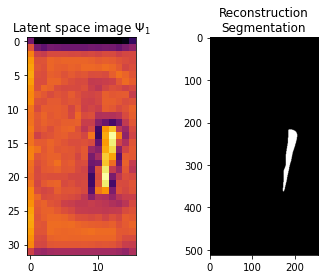

In [8]:
plt.figure()
plt.subplot(121)
plt.title("Latent space image $\Psi_1$")
plt.imshow(latent.squeeze(), cmap='inferno')

plt.subplot(122)
plt.title("Reconstruction\nSegmentation")
plt.imshow(reconstruction.squeeze(), cmap='gray')